# Web Scraping for Indeed.com & Predicting Salaries

### Scraping job listings from Indeed.com

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import sys
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
url = "http://www.indeed.com/jobs?q=data+scientist&l=New+York%2C+NY&start=1"

In [ ]:
# try out scraping function on a single page to see if it scrapes the right contents successfully

response = requests.get(url)
soup = BeautifulSoup(response.content)
jobs=[]
for post in soup.find_all('div', {'class':' row result'}):
    job={}
    job['title'] = post.find('a').get('title')
    try:
        job['company'] = post.find('span', {'itemprop':'name'}).getText()
    except:
        job['company'] = None
    job['location'] = post.find('span', {'class':'location'}).getText()
    job['summary'] = post.find('span', {'class':'summary'}).getText()
    try:
        job['salary'] = post.find('td', {'class':'snip'}).find('nobr').renderContents()
    except:
        job['salary'] = None
    jobs.append(job)
jobs

In [ ]:
# try to convert contents into dataframe to take a look

test = pd.DataFrame(jobs)
test

In [ ]:
# create a function to automatically go through pages and scrape results for more cities

url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Virginia']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.content)
        for post in soup.find_all('div', {'class':' row result'}):
            result={}
            try:
                result['company'] = post.find('span', {'itemprop':'name'}).getText()
            except:
                result['company'] = None
            result['title'] = post.find('a').get('title')
            result['location'] = post.find('span', {'class':'location'}).getText()
            result['summary'] = post.find('span', {'class':'summary'}).getText()
            try:
                result['salary'] = post.find('td', {'class':'snip'}).find('nobr').renderContents()
            except:
                result['salary'] = None
            results.append(result)
       

In [ ]:
# convert results to dataframe
df = pd.DataFrame(results)

In [ ]:
# save raw data to a file

reload(sys)
sys.setdefaultencoding('utf-8')
df.to_csv('~/desktop/dsjobs.csv')

In [ ]:
# Find the entries with annual salary entries, 
# by filtering the entries without salaries or salaries that are not yearly 
#(filter those that refer to hour or week). Also, remove duplicate entries

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df[df.salary.str.contains('hour')==False]
df = df[df.salary.str.contains('week')==False]
df = df[df.salary.str.contains('month')==False]
df = df[df.salary.str.contains('day')==False]

In [ ]:
# clean strings
df.summary = df.summary.apply(lambda x: x.strip())
df.company = df.company.apply(lambda x: x.strip())

In [ ]:
# Convert salary string to number, and average a salary range

df.salary = df.salary.apply(lambda x: x.replace(' a year', ''))
df.salary = df.salary.apply(lambda x: x.replace('$', ''))
df.salary = df.salary.apply(lambda x: x.replace(',', ''))

In [ ]:
def number(x):
    if '-' in x:
        return (int(x.split('-')[0])+int(x.split('-')[1]))/2
    else:
        return int(x)
df.salary = df.salary.apply(number)

### Save cleaned data as a CSV

In [ ]:
df.to_csv('cleandata.csv')

## EDA and Feature Engineering

In [2]:
data = pd.read_csv('cleandata.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
# create binary dependent variable

data['high_salary'] = data.salary.apply(lambda x: 0 if x<np.median(data.salary) else 1)
data.rename(columns={'company': 'employer'}, inplace=True)

In [4]:
# check the benchmark

float(data.high_salary.sum())/len(data.high_salary)

0.5017064846416383

In [5]:
# uniform location to city level

def place(x):
    return x.split(',')[0] + ', ' + x.split(',')[1][0:3]
data.location = data.location.apply(place)

In [6]:
# label categorical feature

le = LabelEncoder()
data['location_num'] = le.fit_transform(data.location)

In [7]:
# create a categorical feature from 'title' to identify the hierachy of titles

def position(x):
    if 'Manager' in x:
        return 3
    elif 'Principal' in x:
        return 2
    elif 'Senior' in x:
        return 1
    else:
        return 0
data['high_position'] = data.title.apply(position)

### Conduct natural language processing on summary to create text features

In [8]:
# Create text matrix. Use Tfidf instead of Countvectorizer to create standardized text features.

tvec = TfidfVectorizer(stop_words='english')
tvec.fit(data.summary)
words = pd.DataFrame(tvec.transform(data.summary).todense(), columns = tvec.get_feature_names())

In [9]:
# merge text matrix back to the main dataframe

df = pd.concat([data, words], axis=1)

In [10]:
df.head()

,employer,location,salary,summary,title,high_salary,location_num,high_position,000,10,...,world,write,writing,written,xor,xrd,yearly,years,york,zachary
0,Avispa Technology,"Houston, TX",100000,Works with multi-functional teams focused on e...,Data Scientist 5796057,0,28,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DISYS,"Houston, TX",135000,Works with multi-functional teams focused on e...,Principal Data Scientist,1,28,2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baylor College of Medicine,"Houston, TX",60998,External Title: Senior Quality Assurance / Qua...,Senior Quality Assurance / Quality Control (Re...,0,28,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Oscar Technology,"Houston, TX",160000,Work with data scientist to identify data need...,Big Data Analytics Manager,1,28,3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Baylor College of Medicine,"Houston, TX",72120,Uses and customizes statistical graphing tools...,Bioinformatics Programmer II,0,28,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

In [11]:
# utilize random forest to select features

rf = RandomForestClassifier(n_jobs=-1)

X = df.iloc[:,6:].as_matrix()
y = df.high_salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = df.iloc[:,6:].columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(20)

,importance
big,0.044259
data,0.035693
company,0.034145
team,0.025159
location_num,0.022828
scientist,0.022280
high_position,0.018302
looking,0.017426
science,0.014183
lead,0.013826


In [12]:
X = df[['location_num', 'high_position', 'scientist', 'data', 'big', 'company', 'team', 'looking', 'science', 
       'lead', 'research', 'analyze', 'join', 'algorithms', 'modeling', 'derivative']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

### Define functions to fit, optimize and evaluate models

In [13]:
# Difine function to optimize parameters with grid search

def gridsearch(model, params):
    gs = GridSearchCV(model, params, n_jobs=-1)
    gs.fit(X_train, y_train)
    print 'Best parameters: ', gs.best_params_
    print 'Best score on training set: ', gs.best_score_
    print 'Score on test set: ', gs.score(X_test, y_test)

In [14]:
# Define function to train models on whole training set with best parameters from grid search and evaluate performance

def evaluation(model):
    model.fit(X_train, y_train)
    print 'Accuracy score on test set: ', model.score(X_test, y_test)
    return model.predict(X_test), model.predict_proba(X_test)[:,1]

In [15]:
# Define function to print confusion matrix

def confusions(y_pred):
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))
    confusion = pd.DataFrame(conmat, index=['high', 'low'], columns=['pred high', 'pred low'])
    print confusion

In [16]:
# Define function to plot ROC curve

def plot_roc(y_prob):
    fpr = dict()
    tpr = dict()
    roc_auc=dict()
    fpr[1], tpr[1], _ = roc_curve(y_test, y_prob)
    roc_auc[1] = auc(fpr[1], tpr[1])
    
    plt.figure(figsize=[11,9])
    plt.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1], linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for high salary', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

### Random Forest

In [30]:
# utilize grid search to optimize parameters

rf_params = {'n_estimators': [5,10,15,20], 'criterion': ['gini', 'entropy'], 
             'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [3,5,10,None]}

gridsearch(rf, rf_params)

Best parameters:  {'max_features': 'sqrt', 'n_estimators': 15, 'criterion': 'gini', 'max_depth': 5}
Best score on training set:  0.756097560976
Score on test set:  0.590909090909


In [31]:
# use the best model from grid search to check the accuracy score on test set

rf = RandomForestClassifier(max_features=None, n_estimators=15, criterion='entropy', max_depth=5)

rf_pred, rf_prob = evaluation(rf)

Accuracy score on test set:  0.602272727273


In [32]:
# print confusion matrix

confusions(rf_pred)

      pred high  pred low
high         22        26
low           9        31


In [33]:
# print classification report

print classification_report(y_test, rf_pred)

             precision    recall  f1-score   support

          0       0.54      0.78      0.64        40
          1       0.71      0.46      0.56        48

avg / total       0.63      0.60      0.59        88



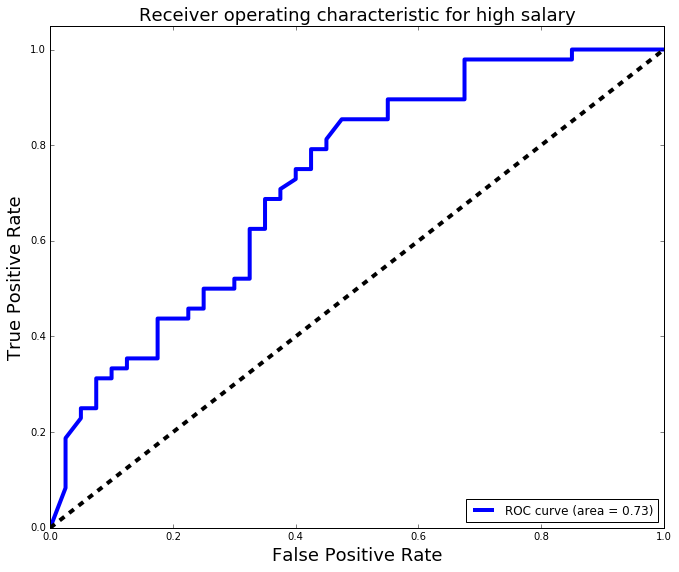

In [34]:
# plot the roc curve and calculate auc

plot_roc(rf_prob)

### Gradient Boosting

In [35]:
# try to use boosting to see if the accuracy score improve

gbc = GradientBoostingClassifier()
gbc_params = {'n_estimators': [100, 200, 250, 300], 'max_features': ['auto', 'sqrt', 'log2', None], 
              'max_depth': [3,5,10,None]}

gridsearch(gbc, gbc_params)

Best parameters:  {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 3}
Best score on training set:  0.712195121951
Score on test set:  0.681818181818


In [36]:
gbc = GradientBoostingClassifier(max_features='sqrt', n_estimators=300, max_depth=3)

gbc_pred, gbc_prob = evaluation(gbc)

Accuracy score on test set:  0.670454545455


In [37]:
confusions(gbc_pred)

      pred high  pred low
high         32        16
low          13        27


In [38]:
print classification_report(y_test, gbc_pred)

             precision    recall  f1-score   support

          0       0.63      0.68      0.65        40
          1       0.71      0.67      0.69        48

avg / total       0.67      0.67      0.67        88



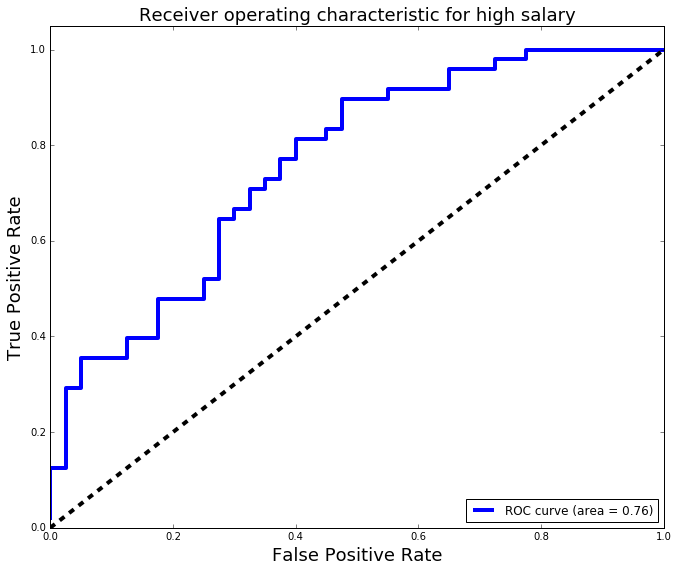

In [39]:
plot_roc(gbc_prob)

### SVM

In [17]:
# create dummies for categorical features

enc = OneHotEncoder(categorical_features=[0,1])
X = enc.fit_transform(X)

In [18]:
sv = svm.SVC(kernel='linear')
sv_params = {'C': 10.**np.arange(-2,3)}

gridsearch(sv, sv_params)

Best parameters:  {'C': 10.0}
Best score on training set:  0.717073170732
Score on test set:  0.659090909091


In [19]:
sv = svm.SVC(kernel='linear', C=10, probability=True)

sv_pred, sv_prob = evaluation(sv)

Accuracy score on test set:  0.659090909091


In [20]:
confusions(sv_pred)

      pred high  pred low
high         27        21
low           9        31


In [21]:
print classification_report(y_test, sv_pred)

             precision    recall  f1-score   support

          0       0.60      0.78      0.67        40
          1       0.75      0.56      0.64        48

avg / total       0.68      0.66      0.66        88



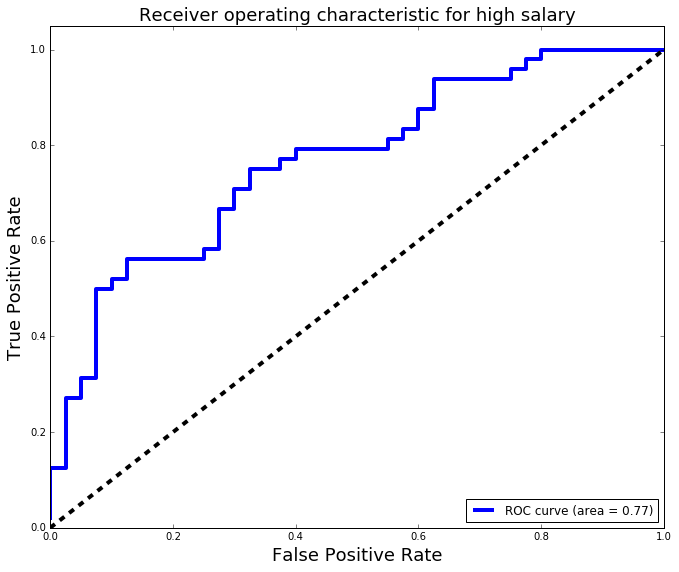

In [22]:
plot_roc(sv_prob)